None을 사용해서 최적화 

1. Lookback window 사이즈를 다르게 주자

2. 리벨런싱 주기를 다르게

3. max_ratio를 다르게

In [1]:
import numpy as np 
import pandas as pd 
import ray

from optimize_multi.object_function import * 
from optimize_multi.optimizer_v2 import run_optimizer
from ryu_tool.mytool import * 

2023-05-08 21:19:14,337	INFO worker.py:1625 -- Started a local Ray instance.


In [6]:
from tqdm import tqdm

In [2]:
price = pd.read_pickle("Data/allstock_reduced.pickle").abs()
spx_mask = pd.read_pickle("Data/spx_mask.pickle")

rtn = price.pct_change(fill_method=None)

In [3]:
rtn_ray = ray.put(rtn)
mask_ray = ray.put(spx_mask)

In [4]:
futures = [run_optimizer.remote(obj_function =obj_sharpe, 
                                rtn_df=rtn_ray,
                                spx_mask=mask_ray,
                                start_year="2006",
                                end_year="2023",
                                rebalancing="Q",
                                look_back_size=lookbacksize,
                                max_ratio=1,
                                shrinkage_method="None") 
           for lookbacksize in [120, 150, 180, 210, 240, 270, 300, 330, 365]]
result = ray.get(futures)

100%|██████████| 68/68 [27:15<00:00, 24.05s/it]


(run_optimizer pid=6644) Jobs Done...


100%|██████████| 68/68 [27:38<00:00, 24.39s/it]


(run_optimizer pid=25160) Jobs Done...


100%|██████████| 68/68 [28:04<00:00, 24.77s/it]


(run_optimizer pid=1452) Jobs Done...


100%|██████████| 68/68 [29:32<00:00, 26.07s/it]


(run_optimizer pid=19216) Jobs Done...


100%|██████████| 68/68 [30:03<00:00, 26.52s/it]


(run_optimizer pid=9016) Jobs Done...


100%|██████████| 68/68 [30:17<00:00, 26.72s/it]


(run_optimizer pid=11860) Jobs Done...


100%|██████████| 68/68 [31:31<00:00, 27.82s/it] [repeated 2x across cluster]


(run_optimizer pid=3952) Jobs Done...


 99%|█████████▊| 67/68 [32:29<00:11, 11.18s/it]


In [5]:
ray.shutdown()

100%|██████████| 68/68 [32:36<00:00, 28.77s/it]


(run_optimizer pid=4244) Jobs Done... [repeated 2x across cluster]


In [8]:
args_lst = [120, 150, 180, 210, 240, 270, 300, 330, 365]
result_dict = {}
weight_dict = {}

for i, arg in tqdm(enumerate(args_lst)):
    rt, weig = simulate_rebalancing(rtn, result[i])
    result_dict[f"Look-Back {str(arg)} Days"] = rt
    weight_dict[str(arg)] = weig

9it [00:18,  2.02s/it]


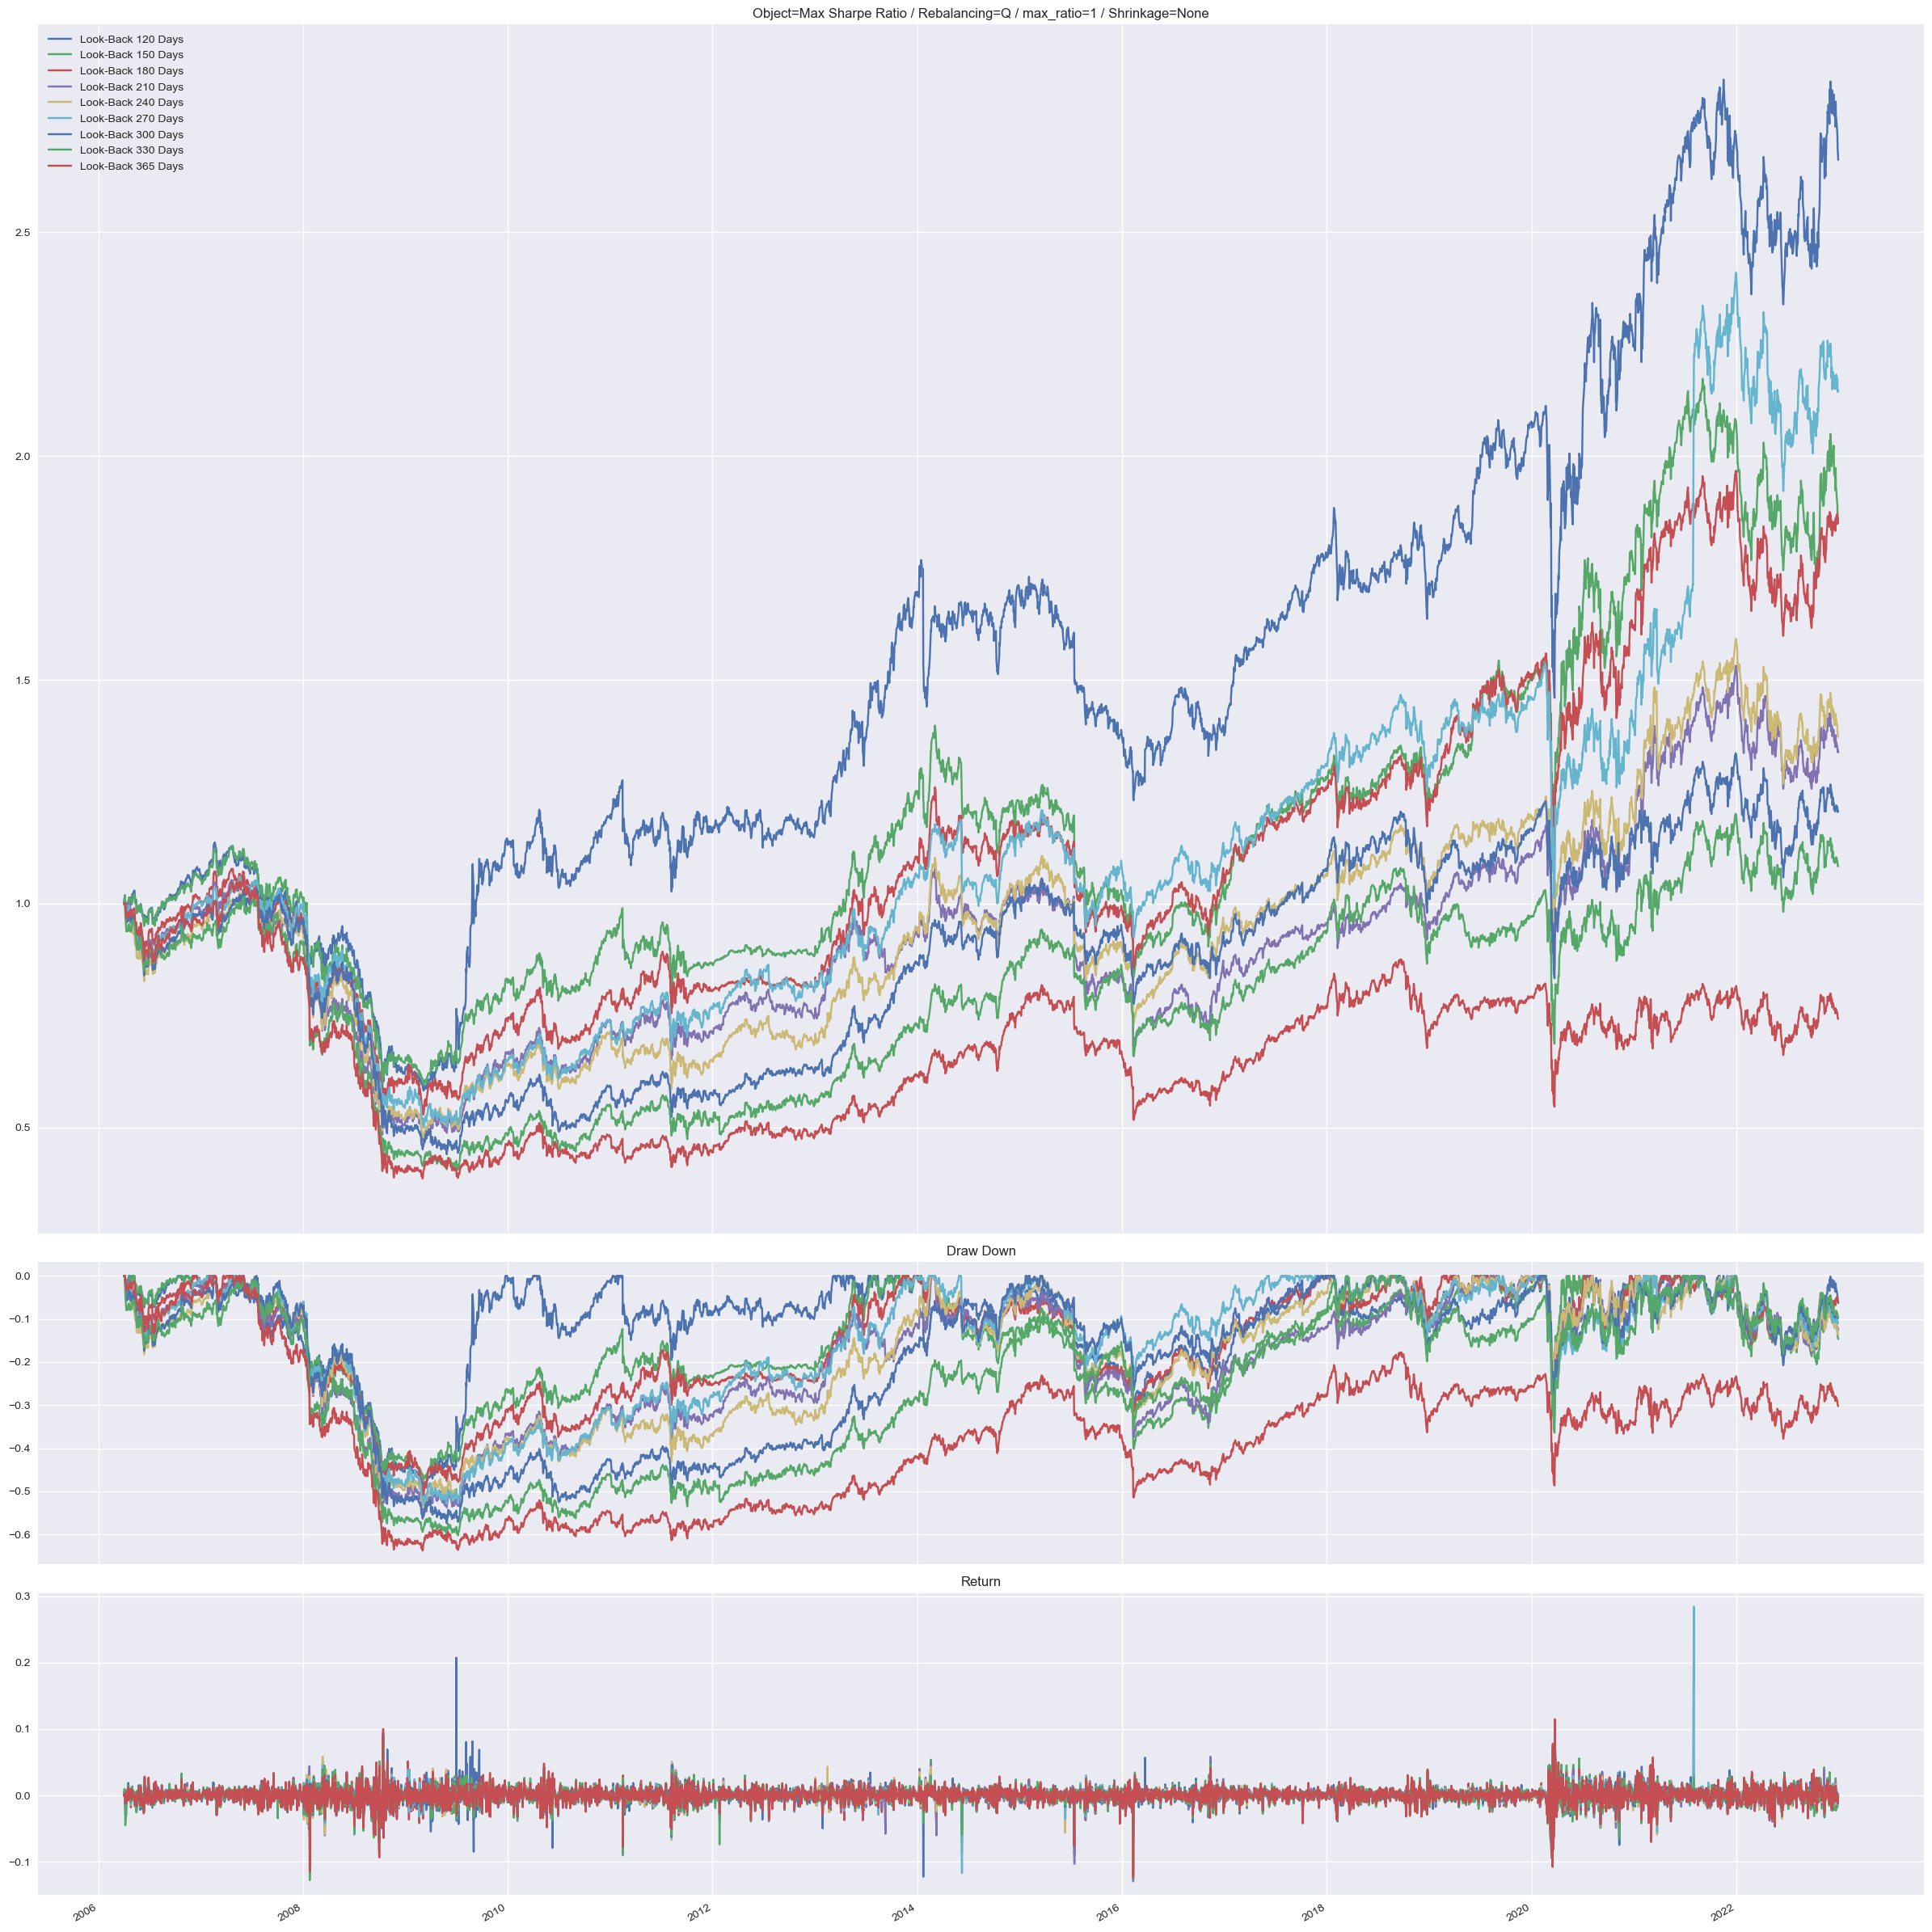

In [16]:
draw_return_result(result_dict,
                   one_plot=True,
                   title="Object=Max Sharpe Ratio / Rebalancing=Q / max_ratio=1 / Shrinkage=None")

In [17]:
stats = print_statistics(result_dict)
stats.columns = [str(day) + "_Days" for day in args_lst]
stats

,120_Days,150_Days,180_Days,210_Days,240_Days,270_Days,300_Days,330_Days,365_Days
CAGR,0.059800,0.037300,0.037000,0.017100,0.018700,0.046100,0.011100,0.004700,-0.017400
Mean,0.109070,0.074740,0.074630,0.048880,0.051380,0.093560,0.041270,0.035020,0.001960
STD,0.221093,0.205609,0.206274,0.216925,0.218241,0.235781,0.222928,0.235724,0.234453
MDD,0.488000,0.473000,0.510000,0.559000,0.536000,0.531000,0.574000,0.602000,0.637000
Sharpe,0.493322,0.363505,0.361801,0.225331,0.235427,0.396809,0.185127,0.148563,0.008360
